## Setup
For my tests, I used a RTX 2060 Super with 8 GB Memory on a PC running Windows 10 with an Intel i7-7000 8 core processor with 16 GB RAM. Let's check if your device has a GPU. 

In [4]:
import tensorflow as tf

Let's check if you have a GPU enabled (A GPU shouldn't be necessary, but speeds of training).

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load and Explore Data

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('enron_test.csv', parse_dates=['new_date'])
df.head()

,Date,From,To,Subject,content,new_date
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),NaN,Here is our forecast\n\n,2001-05-14 23:39:00
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Re:,Traveling to have a business meeting takes the...,2001-05-04 20:51:00
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),Re: test,test successful. way to go!!!,2000-10-18 10:00:00
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),NaN,"Randy,\n\n Can you send me a schedule of the s...",2000-10-23 13:13:00
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Re: Hello,Let's shoot for Tuesday at 11:45.,2000-08-31 12:07:00


Let's check our data for null values and properly clean them up.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1000 non-null   object        
 1   From      1000 non-null   object        
 2   To        995 non-null    object        
 3   Subject   698 non-null    object        
 4   content   1000 non-null   object        
 5   new_date  1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 47.0+ KB


Let's take a look at those emails which are sent to nobody and save that in a separate dataframe. It looks like we can safely drop those rows.

In [9]:
to_na_df = df[df['To'].isna()].copy()
to_na_df

,Date,From,To,Subject,content,new_date
188,"Mon, 1 May 2000 03:56:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),NaN,Re: DSL- Installs,No one will be home on 5/11/00 to meet DSL ins...,2000-05-01 10:56:00
603,"Wed, 13 Dec 2000 08:35:00 -0800 (PST)",frozenset({'messenger@ecm.bloomberg.com'}),NaN,Bloomberg Power Lines Report,Here is today's copy of Bloomberg Power Lines....,2000-12-13 16:35:00
781,"Mon, 1 May 2000 03:56:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),NaN,Re: DSL- Installs,No one will be home on 5/11/00 to meet DSL ins...,2000-05-01 10:56:00
873,"Fri, 7 Jan 2000 16:23:00 -0800 (PST)",frozenset({'owner-strawbale@crest.org'}),NaN,NaN,<4DDE116DBCA1D3118B130080C840BAAD02CD53@ppims....,2000-01-08 00:23:00
885,"Mon, 14 May 2001 09:04:00 -0700 (PDT)",frozenset({'messenger@ecm.bloomberg.com'}),NaN,Bloomberg Power Lines Report,Here is today's copy of Bloomberg Power Lines....,2001-05-14 16:04:00


Let's keep only those emails that are sent to someone.

In [10]:
df = df[~df['To'].isna()]
df.fillna({'Subject':''}, inplace=True)

Let's also remove those emails which are duplicated.

In [11]:
len(df[df.duplicated()])

335

In [12]:
df.drop_duplicates(inplace=True)

Let's create the social network of the emails where each node is a person and each edge is directed from 'From' to 'To' and has a datetime associated with it. Notice that each email has a single author, so we can replace the 'frozenset' with a string in the dataframe.

<AxesSubplot:>

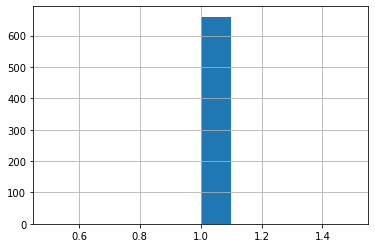

In [13]:
df['From'].map(lambda s: len(eval(s))).hist(bins=10)

In [14]:
df['From'] = df['From'].map(lambda s: set(eval(s)).pop())
df.head(1)

,Date,From,To,Subject,content,new_date
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,frozenset({'tim.belden@enron.com'}),,Here is our forecast\n\n,2001-05-14 23:39:00


<AxesSubplot:>

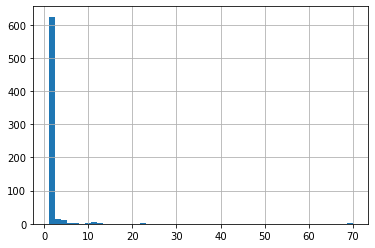

In [15]:
df['To'] = df['To'].map(lambda s: eval(s))
df['To'].map(len).hist(bins=50)

## Create Social Network Graph

Let's create the social network graph by creating a list of datetime and emails being sent by a specific email.

In [16]:
from collections import defaultdict

In [17]:
email_datetime_emaildd = defaultdict(dict)
for i, row in df.iterrows():
    from_email = row['From']
    datetime = row['new_date']
    to_emails = row['To'] 
    for to_email in to_emails:
        email_datetime_emaildd[from_email][datetime] = to_email

Notice we can calculate the number of senders and also see who sends out the most emails. From a quick inspection we can actually see that most emails contained in this dataset are one-offs, i.e. have no thread as the count would have to be at least 2 recipients for an email thread. 

In [18]:
print('Number of Senders:', len(email_datetime_emaildd))

Number of Senders: 39


In [19]:
email_num_recipients = {email: len(datetime_emaildd) for email, datetime_emaildd in email_datetime_emaildd.items()}
sorted(email_num_recipients.items(), key = lambda en: en[1])

[('1.11913372.-2@multexinvestornetwork.com', 1),
 ('market-reply@listserv.dowjones.com', 1),
 ('rebecca.cantrell@enron.com', 1),
 ('paul.kaufman@enron.com', 1),
 ('yild@zdemail.zdlists.com', 1),
 ('bounce-news-932653@lists.autoweb.com', 1),
 ('public.relations@enron.com', 1),
 ('stephanie.miller@enron.com', 1),
 ('tracy.arthur@enron.com', 1),
 ('bobregon@bga.com', 1),
 ('subscriptions@intelligencepress.com', 1),
 ('tim.heizenrader@enron.com', 1),
 ('rob_tom@freenet.carleton.ca', 1),
 ('calxa@aol.com', 1),
 ('billc@greenbuilder.com', 1),
 ('frank.hayden@enron.com', 1),
 ('matt@fastpacket.net', 1),
 ('jfreeman@ssm.net', 1),
 ('kim.ward@enron.com', 1),
 ('grensheltr@aol.com', 1),
 ('yahoo-delivers@yahoo-inc.com', 1),
 ('perfmgmt@enron.com', 1),
 ('alyse.herasimchuk@enron.com', 1),
 ('lisa.jacobson@enron.com', 1),
 ('christi.nicolay@enron.com', 1),
 ('richard.shapiro@enron.com', 1),
 ('gthorse@keyad.com', 1),
 ('tiffany.miller@enron.com', 1),
 ('philip.polsky@enron.com', 1),
 ('mark.whitt@

Now let's sort our email recipients by their increasing datetime and then the senders by the number of their recipients. By this simple step we see, actually, that our dataset is not really graph like. It is more like a bipartite graph. Further, most of the emails seem to be directed to or directed from Philip Allen as either 'pallen@encron.com', 'philip.allen@enron.com', philip.k.allen@enron.com'. Looking at the timestamps in the few instances with more than one recipient seem to indicate a lack of an email thread, except perhaps for sarah.novosel@enron.com, and jsmith@austintx.com and ina.rangel@enron.com with Philip Allen.

In [20]:
email_datetime_emaildd = {email: dict(sorted(datetime_emaild.items())) for email, datetime_emaild in email_datetime_emaildd.items()}
email_datetime_emaildd = dict(sorted(email_datetime_emaildd.items(), key = lambda ede: len(ede[1])))
print(email_datetime_emaildd['sarah.novosel@enron.com'])
print(email_datetime_emaildd['jsmith@austintx.com'])
print(email_datetime_emaildd['ina.rangel@enron.com'])

{Timestamp('2000-12-13 10:17:00'): 'susan.mara@enron.com', Timestamp('2000-12-13 10:28:00'): 'susan.mara@enron.com'}
{Timestamp('2000-12-11 16:27:00'): 'phillip.k.allen@enron.com', Timestamp('2000-12-12 13:27:00'): 'phillip.k.allen@enron.com'}
{Timestamp('2000-12-05 15:31:00'): 'amanda.huble@enron.com', Timestamp('2000-12-18 20:22:00'): 'arsystem@mailman.enron.com', Timestamp('2001-02-21 15:22:00'): 'john.lavorato@enron.com', Timestamp('2001-03-08 14:46:00'): 'information.management@enron.com'}


We can more easily see the focus of this dataset is Paul Allen by drawing the graph of the network. Now that we know Philip Allen has 595 recipients it is easy to tell that the center node is himself.

In [21]:
import networkx as nx

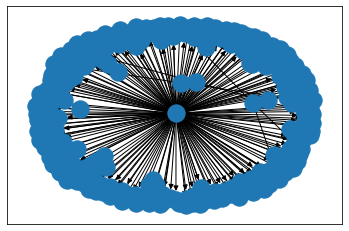

In [22]:
G = nx.from_pandas_edgelist(df, 'From', 'To', edge_attr ='new_date', create_using=nx.DiGraph())
nx.draw_networkx(G, arrows=True,  with_labels=False)

Now given the structure of our dataset we can see we can divide our dataset into what Philip Allen sent or someone else.

In [23]:
df[df['From'] == 'phillip.allen@enron.com'].groupby('To').count()['Subject'].sort_values()

To
(stephane.brodeur@enron.com)                              1
(brian.hoskins@enron.com)                                 1
(mark.miles@enron.com)                                    1
(kathy.moore@enron.com)                                   1
(paul.lucci@enron.com, kenneth.shulklapper@enron.com)     1
                                                         ..
(keith.holst@enron.com)                                  24
(pallen70@hotmail.com)                                   28
(ina.rangel@enron.com)                                   37
(stagecoachmama@hotmail.com)                             40
(jsmith@austintx.com)                                    41
Name: Subject, Length: 202, dtype: int64

Let's get the datetime recipient list of Philip Allen and generate the list of his recipients and when he contacted them in order to determine if there were a chain of emails sent to the same person.

In [24]:
email_datetimesd = defaultdict(list)

for datetime, email in email_datetime_emaildd['phillip.allen@enron.com'].items():
    email_datetimesd[email].append(datetime)
email_datetimesd = dict(sorted(email_datetimesd.items(), key=lambda eds: len(eds[1])))

In [25]:
#email_datetimesd

In [26]:
#pd.TimeStamp.strptime(Timestamp('2001-05-14 23:39:00'), "%Y-%m-%d %H:%M:%S%f")

## Further Investigation: Length of Emails and Subject Lines

Let's also consider the length in characters of Philip Allen's emails. Some of these emails are very long and probably should be looked at and may be a series of forwarded emails.

<AxesSubplot:>

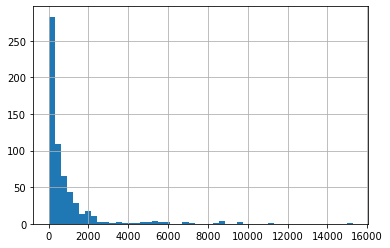

In [27]:
pa_df = df[df['From'] == 'phillip.allen@enron.com']
pa_df['content'].str.len().hist(bins=50)

Finally, let us consider the distribution of the Subject. Notice the frequency of 'Re:' in the subject lines. This could help us determine short threads of emails or we could classify documents as being a reply or not.

In [28]:
df['Subject'].value_counts().to_dict()

{'': 194,
 'Re:': 34,
 'Re: Resume': 5,
 'New Notice from Transwestern Pipeline Co.': 5,
 "Re: This morning's Commission meeting delayed": 4,
 'Request from Steve Kean': 4,
 'RE:': 4,
 'Re: The Stage': 4,
 'Re: West Gas 2001 Plan': 3,
 'Investment Structure': 3,
 'Westgate Proforma-Phillip Allen.xls': 3,
 'Re: (No Subject)': 3,
 'California Update 5/4/01': 2,
 'Re: Western Wholesale Activities - Gas & Power Conf. Call': 2,
 'California Summary': 2,
 'Re: Analyst Ashish Mahajan': 2,
 'Daily Report': 2,
 'Enron Response to San Diego Request for Gas Price Caps': 2,
 'Re: Resumes': 2,
 'Re: SM134': 2,
 'Re: #30': 2,
 'Re: Inquiry....': 2,
 'Alliance netback worksheet': 2,
 'Re: General Issues': 2,
 'Re: 2- SURVEY/INFORMATION EMAIL 5-14- 01': 2,
 'Re: Analyst Resume - Rafael Avila': 2,
 'Re: Please respond': 2,
 'Re: New Notice from Transwestern Pipeline Co.': 2,
 'Maps': 2,
 'Re: Western Wholesale Activities - Gas & Power Conf. Call\n Privileged & Confidential Communication Attorney-Client

## Adding Tokens, Entities, and Noun Chunk Features

Now let's add some more features to our data, specifically tokens, named entities, and noun chunks.

In [29]:
from re import sub

In [30]:
def tokenize(text):
    text = sub('[!"#$%&()*+,./:;<=>?@^_`\'{|}~\t\n\\\\\\[\\]-]', ' ', text)
    text = sub(' +', ' ', text).lower()
    return text.split()

In [31]:
df['tokens'] = df['content'].apply(tokenize)

In [32]:
df.head(1)

,Date,From,To,Subject,content,new_date,tokens
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,(tim.belden@enron.com),,Here is our forecast\n\n,2001-05-14 23:39:00,"[here, is, our, forecast]"


In [33]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import spacy

nlp = spacy.load('en_core_web_trf')

Here we need to add in some of the enclitics ('s, 'd), time markers (am pm), and some constant punctuation to the stopwords list. Further, we will take on the noun chunks to form our topics.

In [34]:
ENGLISH_STOP_WORDS = set(ENGLISH_STOP_WORDS) | {'e', '#', '-', "'s", 'd', 'am', 'pm', ''}

This may take over 3 minutes to run. Here we find named entities.

In [35]:
%%time
df['ents'] = df['content'].map(lambda s: [ent.text.replace(' ', '_') for ent in nlp(s).ents if ent.label_ not in {'TIME', 'DATE', 'CARDINAL'}])

Token indices sequence length is longer than the specified maximum sequence length for this model (799 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 24min 5s, sys: 1min 1s, total: 25min 6s
Wall time: 3min 8s


In [37]:
def preprocess_noun_chunk(nc):
    nc = nc.text.replace(' ', '_').lower()
    nc = re.sub('[^a-z_]', '', nc)
    nc = re.sub('^_+', '', nc)
    return nc

This may take more than 3 minutes to run. Here we find noun chunks.

In [38]:
%%time
df['noun_chunks'] = [[preprocess_noun_chunk(nc) for nc in nlp(content).noun_chunks if nc.text.lower() not in ENGLISH_STOP_WORDS] for content in df['content']]

CPU times: user 24min 12s, sys: 59.2 s, total: 25min 11s
Wall time: 3min 9s


In [39]:
df.head(1)

,Date,From,To,Subject,content,new_date,tokens,ents,noun_chunks
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,(tim.belden@enron.com),,Here is our forecast\n\n,2001-05-14 23:39:00,"[here, is, our, forecast]",[],[our_forecast]


## Truncated Enron Word2Vec Embeddings

With a few lines we can create our own Enron Truncated Word2Vec Embedding.

In [40]:
from gensim.models import Word2Vec

/home/robert_ubuntu/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


This will take less than a minute.

In [41]:
%time
w2v_model = Word2Vec(df['tokens'], min_count=1, vector_size=300, workers=12)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


In [42]:
# w2v_model.save('enron_truncated_w2v.bin')

Now we'll be able to use our Enron specific embedding to maximize the classificational power of a classification model.

In [43]:
# w2v_model = Word2Vec.load('enron_truncated_w2v.bin')

In [44]:
w2v_model.wv.similar_by_word('allen')

[('k', 0.9992313385009766),
 ('phillip', 0.9923456907272339),
 ('forwarded', 0.9859502911567688),
 ('7041', 0.977257490158081),
 ('rr', 0.9732871651649475),
 ('hunter', 0.9691621661186218),
 ('comnes', 0.9677537679672241),
 ('by', 0.9674532413482666),
 ('giovannini', 0.9662247896194458),
 ('59', 0.9658829569816589)]

### Create Sentence Embeddings for each Email

In [45]:
import numpy as np

In [46]:
def get_sentence_embedding(tokens):
    avg_wv = np.zeros(300)
    for token in tokens[:100]:
        avg_wv = avg_wv + w2v_model.wv.get_vector(token)
    return avg_wv

In [47]:
df['sentence_embedding'] = df['tokens'].map(get_sentence_embedding)

## Classify Emails From or Not From Philip Allen

Let's gather our negative and positive (sentence) embeddings for our emails and create our y labels.

In [48]:
neg_embs = df[df['From'] != 'phillip.allen@enron.com']['sentence_embedding']
neg_labels = [0]*len(neg_embs)
pos_embs = df[df['From'] == 'phillip.allen@enron.com']['sentence_embedding'].sample(n=3*len(neg_embs), random_state=0)
pos_labels = [1]*3*len(neg_embs)

In [49]:
X_embs = np.append(neg_embs, pos_embs)
y_labels = np.append(neg_labels, pos_labels)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [51]:
X_train_embs, X_test_embs, y_train, y_test = train_test_split(X_embs, y_labels, random_state=0, stratify=y_labels)

## Train a Cross-validated Logistic Regression Model Base-line

In [52]:
from sklearn.linear_model import LogisticRegressionCV

In [53]:
lr_clf = LogisticRegressionCV(cv=5, class_weight={0:3, 1:1}, random_state=0).fit(np.vstack(X_train_embs), y_train)
y_pred_test = lr_clf.predict(np.vstack(X_test_embs))

print(classification_report(y_test, y_pred_test))

/home/robert_ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/robert_ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

              precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.92      0.95      0.94        38

    accuracy                           0.90        51
   macro avg       0.88      0.86      0.87        51
weighted avg       0.90      0.90      0.90        51



/home/robert_ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/robert_ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Due to the small size of the negative samples it is difficult to be confident even in our cross-validated scores. However, it does at least appear that we can do better than random chance in respect to recall!

## Train an XGBoost Classifier to see possible performance increase

In [54]:
from xgboost import XGBClassifier

In [55]:
%%time
xgb_clf = XGBClassifier(n_estimators=10, random_state=0)
xgb_clf.fit(np.vstack(X_train_embs), y_train)

[02:57:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 516 ms, sys: 48.6 ms, total: 564 ms
Wall time: 41.1 ms


/home/robert_ubuntu/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
y_pred_test = xgb_clf.predict(np.vstack(X_test_embs))

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.88      0.97      0.93        38

    accuracy                           0.88        51
   macro avg       0.88      0.79      0.83        51
weighted avg       0.88      0.88      0.87        51



It appears that logistic regression outperforms XGBoost in this low data regime. This is inline with my previous experience and makes sense with XGBoost possibly overfitting in the negative class. However, neither model has had a proper hyperparameter search which may make a difference. 

## TFIDF Features for Possible Interpretability

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
neg_texts = df[df['From'] != 'phillip.allen@enron.com']['tokens'].apply(lambda tokens: ' '.join(tokens))
neg_labels = [0]*len(neg_embs)
pos_texts = df[df['From'] == 'phillip.allen@enron.com']['tokens'].apply(lambda tokens: ' '.join(tokens)).sample(n=3*len(neg_embs))
pos_labels = [1]*3*len(neg_embs)

In [59]:
X_texts = np.append(neg_texts, pos_texts)
y_labels = np.append(neg_labels, pos_labels)

In [68]:
vectorizer = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)
X_tfidf = vectorizer.fit_transform(X_texts) 
y_tfidf = y_labels

In [69]:
feature_names = vectorizer.get_feature_names()
#feature_names

In [70]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf,  random_state=0, stratify=y_tfidf)

In [73]:
lr_clf_tfidf = LogisticRegressionCV(cv=5, class_weight={0:3, 1:1}, random_state=0).fit(X_train_tfidf, y_train_tfidf)
y_pred_test_tfidf = lr_clf_tfidf.predict(X_test_tfidf)

print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.85      0.92      0.89        38

    accuracy                           0.82        51
   macro avg       0.78      0.73      0.75        51
weighted avg       0.81      0.82      0.82        51



The performance with TFIDF features of logistic regression appears to be worse than the embeddings. But a proper search for hyperparameters might show a difference, but all else being equal it appears that even a small embedding is helpful.

## Topic Modelling of Philip Allen's emails by Latent Direchlet Allocation

In [74]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

from pprint import pprint

from pyLDAvis import enable_notebook
from pyLDAvis.gensim_models import prepare

We'll restrict our emails to Philip Allen, so that we can get a sense of what topics he was discussing. Only around 50 of the 660 or so emails are not from Philip Allen, so less than 10%.

In [75]:
pa_df = df[df['From'] == 'phillip.allen@enron.com']
print('Number of Philip Allen emails:', len(pa_df))

Number of Philip Allen emails: 609


/home/robert_ubuntu/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We'll do topic modelling by both named entities and noun chunks for comparison. Named entities would allow a subject matter expert to determine groups of related people, places, and companies, while noun chunks would be related concepts.

In [76]:
id2word0 = Dictionary(pa_df['ents'])
corpus0 = [id2word0.doc2bow(ents) for ents in pa_df['ents']]

id2word1 = Dictionary(pa_df['noun_chunks'])
corpus1 = [id2word1.doc2bow(noun_chunks) for noun_chunks in pa_df['noun_chunks']]

/home/robert_ubuntu/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
lda_model0 = LdaModel(corpus=corpus0,
                   id2word=id2word0,
                   num_topics=7,
                   random_state=0,
                   chunksize=400,
                   alpha='auto',
                   per_word_topics=True,
                   iterations=75,
                   passes=3)

enable_notebook()
p = prepare(lda_model0, corpus0, id2word0)
p

/home/robert_ubuntu/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/robert_ubuntu/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.121261 -0.026309       1        1  20.084002
6     -0.237786 -0.012601       2        1  17.984342
5      0.095064  0.102905       3        1  14.136389
2      0.090648 -0.029059       4        1  13.667285
3     -0.053044  0.177912       5        1  12.284688
4      0.005895 -0.079038       6        1  11.273275
0     -0.022037 -0.133810       7        1  10.570019, topic_info=                Term        Freq       Total Category  logprob  loglift
28              Lucy   50.000000   50.000000  Default  30.0000  30.0000
35               HOU   97.000000   97.000000  Default  29.0000  29.0000
41   Phillip_K_Allen  111.000000  111.000000  Default  28.0000  28.0000
2            Phillip  108.000000  108.000000  Default  27.0000  27.0000
10     Phillip_Allen   40.000000   40.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
48             first    7.505039   23.139803   Topic7  -4.4185   1.1212
437             Wade    4.364826   10.912408   Topic7  -4.9605   1.3308
415  Tori_Kuykendall    3.541833    7.304388   Topic7  -5.1694   1.5233
28              Lucy    3.904458   50.704723   Topic7  -5.0719  -0.3168
166       California    3.647687   18.670899   Topic7  -5.1399   0.6143

[339 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
2311      6  0.861536          #9.\n\n\n\n
1078      5  0.766298           $5_billion
2270      2  0.882087                  +5%
2439      6  0.861914                    0
828       6  0.732000                 0.60
...     ...       ...                  ...
85        4  0.265542               second
85        5  0.619597               second
141       2  0.193289                third
141       5  0.773156                third
2373      2  0.931497  thousand_cubic_feet

[420 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 6, 3, 4, 5, 1])

In [78]:
lda_model1 = LdaModel(corpus=corpus1,
                   id2word=id2word1,
                   num_topics=4,
                   random_state=0,
                   chunksize=400,
                   alpha='auto',
                   per_word_topics=True,
                   iterations=75,
                   passes=3)

enable_notebook()
p = prepare(lda_model1, corpus1, id2word1)
p

/home/robert_ubuntu/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/robert_ubuntu/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.102013 -0.067353       1        1  30.539616
1     -0.097635 -0.016920       2        1  27.042912
2      0.190709 -0.051033       3        1  24.180325
0      0.008939  0.135306       4        1  18.237147, topic_info=            Term         Freq        Total Category  logprob  loglift
207          hou  1046.000000  1046.000000  Default  30.0000  30.0000
195       ectect   285.000000   285.000000  Default  29.0000  29.0000
1191        mail   146.000000   146.000000  Default  28.0000  28.0000
345           na   226.000000   226.000000  Default  27.0000  27.0000
1516         pdx   104.000000   104.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
30       phillip    12.045388    71.261519   Topic4  -5.7008  -0.0760
112        power     7.916393    32.189938   Topic4  -6.1205   0.2990
195       ectect    10.390711   285.178911   Topic4  -5.8485  -1.6105
78           ect     8.875790   173.790356   Topic4  -6.0061  -1.2728
848   the_office     7.013693    22.978163   Topic4  -6.2416   0.5150

[257 rows x 6 columns], token_table=      Topic      Freq                          Term
term                                               
500       1  0.088856                              
500       2  0.088856                              
500       3  0.777486                              
500       4  0.066642                              
3629      4  0.891991               a_bond_issuance
...     ...       ...                           ...
1929      2  0.077989                          wade
1929      4  0.857883                          wade
405       1  0.938505                          west
3626      2  0.895494  western_wholesale_activities
1402      4  0.916648                  your_mailbox

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

## Summary

It appears that with further study and investigation the topics of Philip Allen's emails could be discovered and his major collaborators found through determining the time differences of the emails as was setup to be calculated above. Especially useful would be the other half of the conversation in the emails. However, per person, an analysis could be done on the topics for a few of the major recipients of Allen's emails.